In [1]:
from loader import Loader
from sklearn import svm
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 
import numpy as np
import random

def flatten_image (X, length):
    X_flatten = np.empty([length,16*15])
    for i in range (length):
        X_flatten[i] = X[i].flatten()
    return X_flatten

def add_noise (X, intensity):
    examples, imsize = np.shape(X)
    for i in range (examples):
        noise = np.random.normal(0,1, imsize)
        X[i] += intensity*noise
    return X

def cross_val_with_noise (X,y,k,intensity,clf):
    scores = np.zeros(k)
    fold_len = int(len(X)/k)
    X_test = X[0:fold_len, :]
    y_test = y[0:fold_len]
    X_train = X[fold_len:, :]
    y_train = y[fold_len:]
    
    X_train = add_noise(X_train, intensity)
    
    for i in range(k):
        clf.fit(X_train,y_train)
        y_predict = clf.predict(X_test)
        mismatch = 0
        for j in range(len(y_test)):
            if y_test[j] != y_predict[j]:
                mismatch+=1
        scores[i] = (1-mismatch/len(y_test))*100
        X_test = X[i*fold_len:(i+1)*fold_len, :]
        
        y_test = y[i*fold_len:(i+1)*fold_len]
        X_train = np.append(X[0:i*fold_len, :], X[(i+1)*fold_len:, :], axis = 0)
        y_train = np.append(y[0:i*fold_len], y[(i+1)*fold_len:], axis = 0)
        
        X_train = add_noise(X_train, intensity)
        
    return scores;

from PIL import Image, ImageOps
def cross_val_with_augment (X,y,k,clf): #Cross-validation where the validation set does not have augmented data
    fold_len = int(len(X)/k)
    scores = np.zeros(k)
    X_val = X[0:fold_len :]
    y_val = y[0:fold_len]
    X_train = X[fold_len:, :]
    y_train = y[fold_len:]

    for fold in range(k):
        
        for i in range(900):
            im = X_train[i]
            im = im/6.0 
            im = Image.fromarray(np.uint8(im*255), mode="L")
            im = ImageOps.pad(im, (31, 30), 3)
            angle = random.randint(-25, 25)
            im = im.rotate(angle)
            im = ImageOps.fit(im, (15, 16))
            im = np.array(im)
            im = im / 255.0*6.0
            X_train = np.concatenate((X_train,[im]),axis=0)
            y_train = np.concatenate((y_train,[y_train[i]]),axis=0)
        
        X_train = flatten_image(X_train, 1800)
        X_val = flatten_image(X_val, 100)      
        clf.fit(X_train,y_train)
        y_predict = clf.predict(X_val)
        mismatch = 0
        for j in range(len(y_val)):
            if y_val[j] != y_predict[j]:
                mismatch+=1
        scores[fold] = (1-mismatch/len(y_val))*100
        
        X_val = X[fold*fold_len:int(fold+1)*fold_len]     
        y_val = y[fold*fold_len:int(fold+1)*fold_len]
        X_train = np.append(X[0:fold*fold_len, :], X[(fold+1)*fold_len:, :], axis = 0)        
        y_train = np.append(y[0:fold*fold_len], y[(fold+1)*fold_len:], axis = 0)
        
    return scores

In [3]:
dataset = Loader()
dataset.pca(n_comp=75)

In [6]:
accuracy = 0
sc = []
mean_sc = []
var_sc = []
n_comps = [25,50,75,100,150,240]
for n_comp in n_comps:
    
    dataset.pca(n_comp=n_comp)
    X, y = dataset.getWholeTrainSet(pca=True)
    clf = svm.SVC(kernel='linear')
    scores = cross_val_score(clf,X,y,cv=5)
    sc.append(scores)
    mean_sc.append(scores.mean())
    var_sc.append(scores.var())
for i in range(6):
    print("PCA", n_comps[i])
    for k in range(5):
        print("CV", k, ":", sc[i][k]*100)
    print("mean:", mean_sc[i]*100, ", var:", var_sc[i]*100)


PCA 25
CV 0 : 95.0
CV 1 : 96.0
CV 2 : 97.0
CV 3 : 95.5
CV 4 : 96.5
mean: 96.0 , var: 5.000000000000009e-05
PCA 50
CV 0 : 95.0
CV 1 : 97.5
CV 2 : 98.0
CV 3 : 96.0
CV 4 : 95.5
mean: 96.39999999999999 , var: 0.00013400000000000022
PCA 75
CV 0 : 97.0
CV 1 : 97.0
CV 2 : 98.5
CV 3 : 96.5
CV 4 : 96.5
mean: 97.09999999999998 , var: 5.40000000000001e-05
PCA 100
CV 0 : 97.0
CV 1 : 97.0
CV 2 : 98.5
CV 3 : 95.5
CV 4 : 96.5
mean: 96.89999999999999 , var: 9.400000000000017e-05
PCA 150
CV 0 : 96.5
CV 1 : 97.5
CV 2 : 98.5
CV 3 : 95.5
CV 4 : 96.5
mean: 96.89999999999999 , var: 0.00010400000000000018
PCA 240
CV 0 : 96.0
CV 1 : 97.5
CV 2 : 98.0
CV 3 : 95.5
CV 4 : 96.5
mean: 96.7 , var: 8.600000000000015e-05


In [7]:
noise_opt = 0.1
c_opt = 5.0
dataset.pca(n_comp=75)

accuracy = 0
for n in range(500):
    
    X, y = dataset.getNoisySet(intensity = noise_opt, pca=True, set="train")
    clf = svm.SVC(C=c_opt)
    clf.fit(X,y)
    X_test, y_test = dataset.getWholeTestSet(pca=True)
    y_predict = clf.predict(X_test)
    mismatch = 0
    for i in range(len(y_test)):
        if y_test[i] != y_predict[i]:
            mismatch+=1
    accuracy += (1-mismatch/len(y_test))/5
print ("Test accuracy:", accuracy , "%")

Test accuracy: 97.73500000000011 %


In [4]:
#dataset.augment()
dataset.pca(n_comp=50)
acc_matrix = np.zeros([8,6])
num = 100
for N in range(num):
    i = 0
    for C in [1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 7.5, 10.0]:
    
        j = 0
        for noise_int in [0.0,0.1,0.2,0.3,0.4,0.5]:
            X, y = dataset.getWholeTrainSet(pca=True, shuffle=True)
            clf = svm.SVC(C=C)
            scores = cross_val_with_noise(X,y,10,noise_int,clf)
            acc_matrix[i,j] += np.mean(scores)/num
            j+=1
        i+=1
    
print(acc_matrix)

10
30
[[97.46 97.66 97.7  97.74 97.44 97.28 97.34]
 [97.52 97.62 98.04 97.66 97.72 97.42 97.32]
 [97.76 97.46 97.74 97.76 97.7  97.44 97.5 ]
 [97.82 98.04 97.72 97.7  97.7  97.84 97.32]
 [97.88 97.66 97.98 97.88 97.72 97.56 97.3 ]
 [97.78 97.74 97.82 97.72 97.78 97.66 97.38]
 [97.94 98.02 97.6  97.88 97.58 97.62 97.4 ]
 [97.88 97.86 97.68 97.82 97.8  97.68 97.42]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]


In [38]:
crange = np.arange(0.1,1,0.01)
accs = np.zeros(len(crange))
i = 0
dataset.pca(n_comp=75)
X, y = dataset.getWholeTrainSet(shuffle=True, pca=True)
X_test, y_test = dataset.getWholeTestSet(shuffle=True, pca=True)
for C in crange:
    clf = svm.SVC(C=C)
    clf.fit(X,y)
    y_predict = clf.predict(X_test)
    mismatch = 0
    for j in range(len(y_test)):
        if y_test[j] != y_predict[j]:
            mismatch+=1
    accuracy = (1-mismatch/len(y_test))
    accs[i] = accuracy*100
    i+=1
print(accs)

[95.1 95.2 95.2 95.6 95.6 95.7 95.7 95.7 95.9 96.  96.1 96.2 96.2 96.3
 96.5 96.6 96.6 96.5 96.5 96.5 96.5 96.5 96.5 96.6 96.7 96.7 96.8 96.9
 96.9 96.9 97.  96.9 96.9 96.9 96.9 96.9 96.9 96.9 96.9 96.9 97.1 97.1
 97.1 97.1 97.1 97.1 97.1 97.1 97.1 97.1 97.1 97.2 97.2 97.2 97.2 97.2
 97.2 97.2 97.2 97.1 97.1 97.1 97.1 97.1 97.2 97.2 97.2 97.2 97.2 97.2
 97.2 97.2 97.2 97.3 97.4 97.4 97.4 97.4 97.4 97.4 97.4 97.4 97.4 97.4
 97.4 97.4 97.4 97.4 97.4 97.4]


In [6]:
X, y = dataset.getWholeTrainSet(shuffle=True)
print(np.shape(X), np.shape(y))
c_opt = 1.0
noise_opt = 0.0
i = 0
Cs = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
accuracies = np.zeros(8)
num = 10
for c in Cs:
    for N in range(num):
        clf = svm.SVC(C=c)
        scores = cross_val_with_augment(X,y,10,clf)
        #scores = cross_val_score(clf,X_aug,y_aug,cv=10)
        accuracies[i] += scores.mean()/num
    i+=1
print(accuracies)

(1000, 16, 15) (1000,)
[95.5  98.21 98.34 98.4  98.34 98.4 98.34  98.3 ]


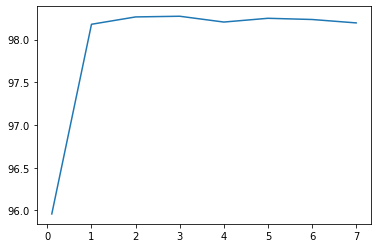

In [25]:
import matplotlib.pyplot as plt 

plt.plot(Cs, accuracies)

In [7]:
accuracy = 0
dataset.augment_self(100)
X, y = dataset.getWholeTrainSet(flat=True)
print(np.shape(X), np.shape(y))
for n in range(100):
    
    
    clf = svm.SVC(C=5.0)
    clf.fit(X,y)
    X_test, y_test = dataset.getWholeTestSet(flat=True)
    y_predict = clf.predict(X_test)
    mismatch = 0
    for i in range(len(y_test)):
        if y_test[i] != y_predict[i]:
            mismatch+=1
    accuracy += (1-mismatch/len(y_test))
print ("Test accuracy:", accuracy , "%")

(2000, 240) (2000,)
Test accuracy: 98.19999999999995 %
